In [1]:
%matplotlib inline

In [2]:
import sys
sys.path.insert(0, "../")
sys.path.insert(0, "../dataset_generator/")

import torch
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import scipy.stats
#plt.style.use("project_style.mplstyle")
from tqdm import tqdm

import stats
import environments
import analysis_tools

In [3]:
if trajectories := True:
    model_type = "RNN"
else:
    model_type = "FF"
    
path = f"../models/al1_10_l2_0"
model, params = analysis_tools.load_model(path, device = "cpu", model_type = model_type) # model of interest
print(params)
timesteps = 5000 # timesteps per sequence
samples = 30 # of samples for each environment

{'epochs': 100, 'batch_size': 64, 'lr': 0.0001, 'al1': 10.0, 'l2': 0, 'nodes': 500, 'outputs': 100, 'reset_interval': 10, 'context': True}


In [4]:
envs = environments.Environments()
envs = list(envs.envs) # :)

In [5]:
centers = np.zeros((len(envs), samples, params["outputs"], 2))

high_si_centers = []
masks = []

states = np.zeros(())
for i, env in enumerate(tqdm(envs)):
    sequence = samples*[env] # sample environment several times
    x, r, v, c = analysis_tools.test_dataset(sequence, timesteps = timesteps, 
                                             context = params["context"], trajectories = trajectories)
    dataset = [((x[0][i,None], x[1][i,None]), x[1][i,None]) for i in range(len(sequence))] # repackage
    
    g, p, current_centers, preds = model.inference(dataset)
    centers[i] = current_centers
    
    mask, info = analysis_tools.spatial_information_selection(p, r, [32, 32]*len(p));
    high_si_centers.append(current_centers[:,mask])

    ###############################################
    mask = np.prod(np.linalg.norm(current_centers, axis=-1) > 0, axis = 0).astype("bool")
    masks.append(mask)

  0%|          | 0/6 [00:00<?, ?it/s]/home/m/Documents/phd/VPC/notebooks/stats.py:93: RuntimeWarning: divide by zero encountered in log2
  spatial_information = np.nansum(occupancy*mean_bin_rate*np.log2(mean_bin_rate/mean_rate[:,None,None]), axis = (1, 2))
/home/m/Documents/phd/VPC/notebooks/stats.py:93: RuntimeWarning: invalid value encountered in multiply
  spatial_information = np.nansum(occupancy*mean_bin_rate*np.log2(mean_bin_rate/mean_rate[:,None,None]), axis = (1, 2))
100%|██████████| 6/6 [01:20<00:00, 13.50s/it]


In [18]:
nonzero_centers = [centers[i, np.linalg.norm(centers[i], axis=-1) > 1e-2] for i in range(len(centers))]
#nonzero_centers = high_si_centers
#centers = nonzero_centers

In [19]:
lims = np.array([-1.5, 1.5, -1.5, 1.5])*1.05

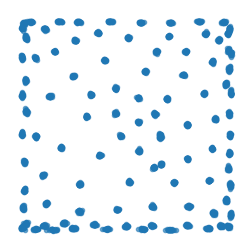

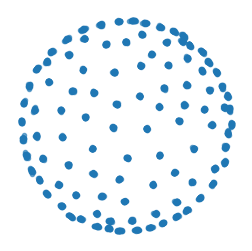

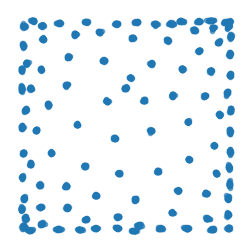

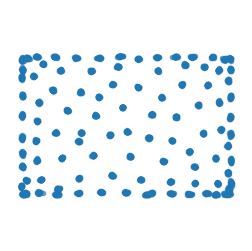

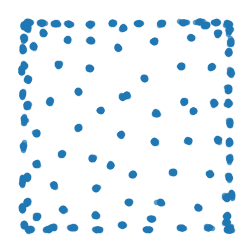

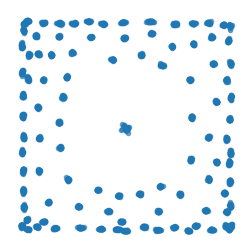

In [20]:
for i, cent in enumerate(nonzero_centers):
    plt.figure(figsize = (3,3))
    plt.plot(cent[...,0], cent[...,1], ".", alpha = 0.6)
    plt.axis("equal")
    plt.axis("off")
    #plt.savefig(f"./figures/{envs[i]}_phase_kd")
    plt.show()

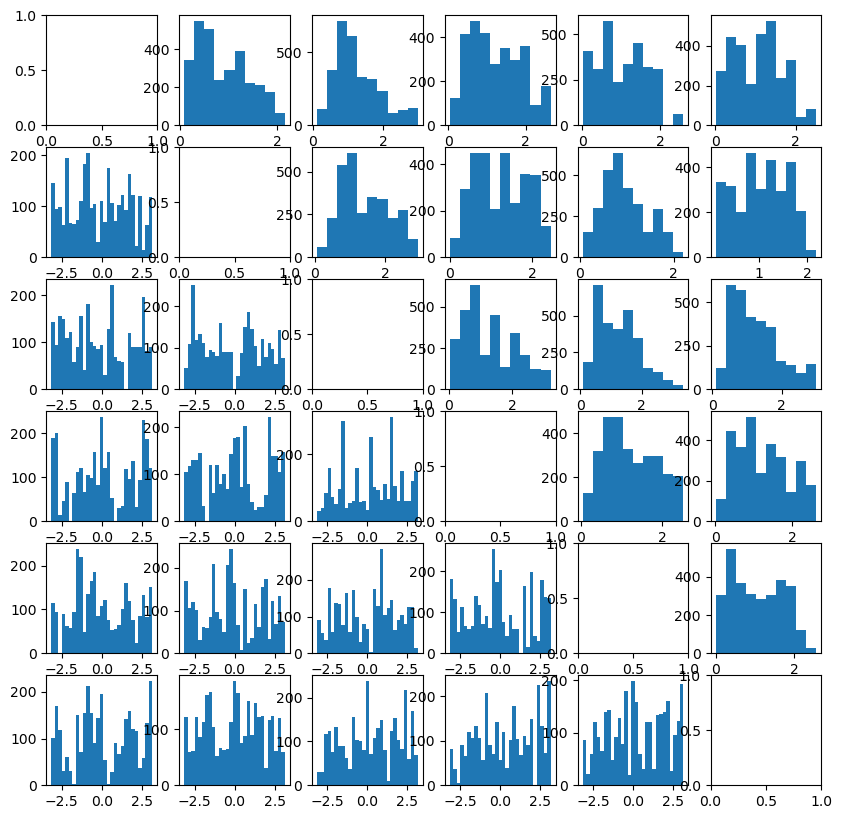

In [9]:
nb = 30
theta_bins = np.linspace(-np.pi, np.pi, nb)
fig, ax = plt.subplots(6,6,figsize = (10,10))
for i, a in enumerate(centers):
    for j, b in enumerate(centers):
        diff = b - a
        if j % 6 > i:
            ax[i, j % 6].hist(np.linalg.norm(diff.reshape(-1, 2), axis=-1))
        
        if j % 6 < i:
            thetas = np.arctan2(diff[...,1], diff[...,0])
            ax[i, j % 6].hist(thetas.reshape(-1), bins = theta_bins)

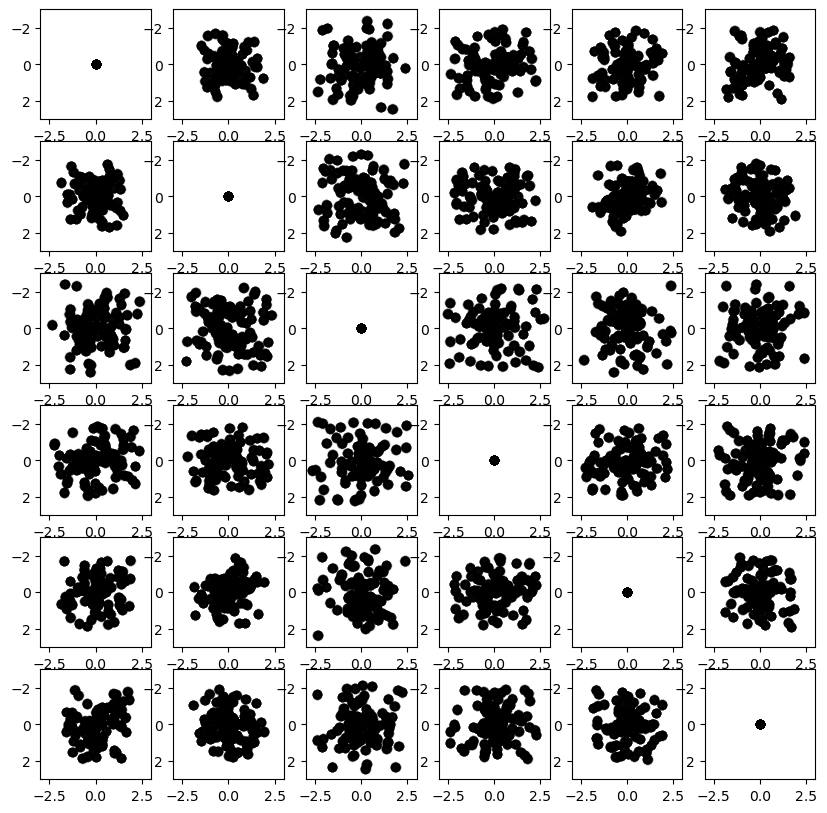

In [10]:
nb = 30
lims = np.array([-1.5, 1.5, 1.5, -1.5])*2

theta_bins = np.linspace(-np.pi, np.pi, nb)
fig, ax = plt.subplots(6,6,figsize = (10,10))
for i, a in enumerate(centers):
    for j, b in enumerate(centers):
        joint_mask = (masks[i]*masks[j]).astype("bool")
        diff = b[:,joint_mask] - a[:,joint_mask]
        ax[i, j % 6].plot(diff[...,0], diff[...,1], "ok", alpha = 0.1)    
        ax[i, j % 6].axis(lims)

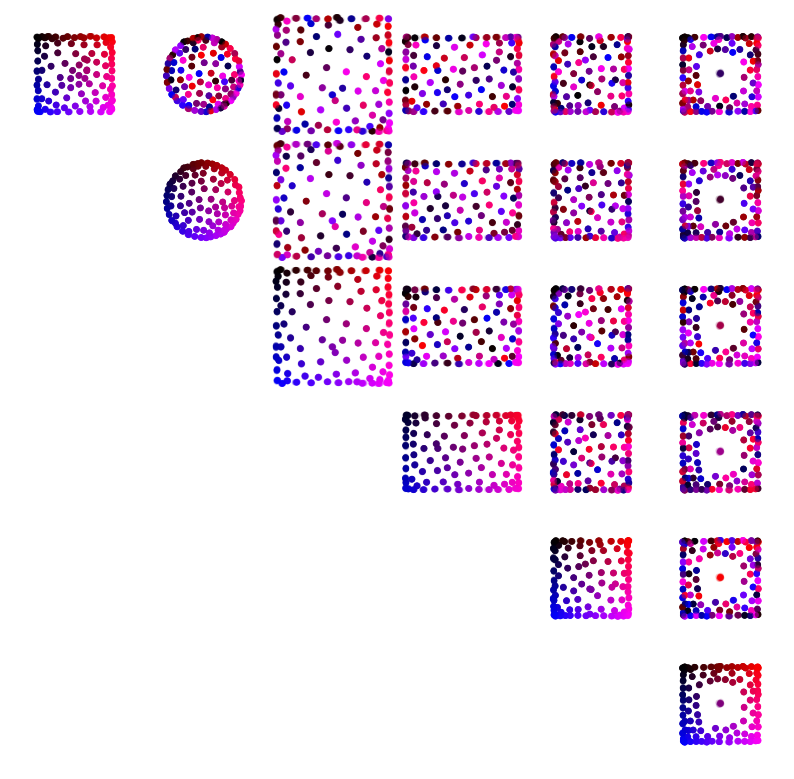

In [11]:
nb = 30
lims = np.array([-1.5, 1.5, 1.5, -1.5])*1.1

theta_bins = np.linspace(-np.pi, np.pi, nb)
fig, ax = plt.subplots(6,6,figsize = (10,10))

def spatial_rgb(pos):
    lim = np.amax(np.abs(pos))
    
    shifted = (pos - np.amin(pos))/(np.amax(pos) - np.amin(pos))
    # scale to (0, 1)
    
    col_r = shifted[...,0]
    col_b = shifted[...,1]
    col_g = np.zeros(col_b.shape)
    rgb = np.stack((col_r, col_g, col_b), axis = -1)
    return rgb

s = 20
alpha = 0.15

for i, a in enumerate(centers):
    for j, b in enumerate(centers):
        joint_mask = (masks[i]*masks[j]).astype("bool")

        ax[i, j % 6].axis(lims)
        ax[i, j % 6].set_aspect("equal")
        ax[i, j % 6].axis("off")
        
        colors = spatial_rgb(a)
        c = colors[:,joint_mask]
        c = c.reshape(-1, 3)
        
        if i == j:
            ax[i, j % 6].scatter(a[:,joint_mask,0].ravel(), a[:,joint_mask,1].ravel(), c = c, s = s, alpha = alpha, edgecolor = "None")

        if j % 6 > i:
            ax[i, j % 6].scatter(b[:,joint_mask,0].ravel(), b[:,joint_mask,1].ravel(), c = c, s = s, alpha = alpha, edgecolor = "None")
        #if j % 6 < i:
        #    ax[i, j % 6].scatter(a[:,joint_mask,0].ravel(), a[:,joint_mask,1].ravel(), c = c)
        
plt.subplots_adjust(wspace = 0, hspace = -0.1)